# Simple ARIMA Model for Non-Seasonal Time-Series Forecast

Our goal in this challenge is to apply the basic concepts of time series analysis to one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

##  1. Load Data
Let's start by loading the Time Series of the challenge. Run the line below to download the dataset as a CSV file, then load the CSV in a DataFrame.

In [1]:
!curl https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/09-Time-Series/www_usage.csv > data/www_usage.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   377  100   377    0     0   1675      0 --:--:-- --:--:-- --:--:--  1729


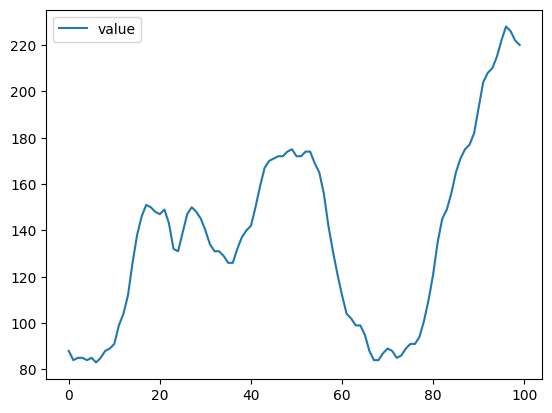

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/www_usage.csv', names=['value'], header=0)
y = df.value

df.plot();

This abstract time series does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regressive Moving Average (ARIMA) models.


## 2. Build ARIMA Model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time series (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the moving average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure Stationarity

ARIMA models apply to "stationary" time series only.

👉 Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [4]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Assuming you have already loaded your data into a DataFrame df
# and the time series data is in a column named 'value'

# Perform the Augmented Dickey-Fuller test
result = adfuller(df['value'])
adf_statistic, p_value = result[0], result[1]

# Print the results
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

# Check for stationarity
if p_value > 0.05:
    print("The time series is not stationary. p-value is greater than 0.05.")
else:
    print("The time series is stationary. p-value is less than 0.05.")

ADF Statistic: -2.464239717203369
p-value: 0.12441935447109442
The time series is not stationary. p-value is greater than 0.05.


The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat the process on the differentiated series if you want the *second difference*, etc...

👉 Find the minimum order of differencing we need to make it stationary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

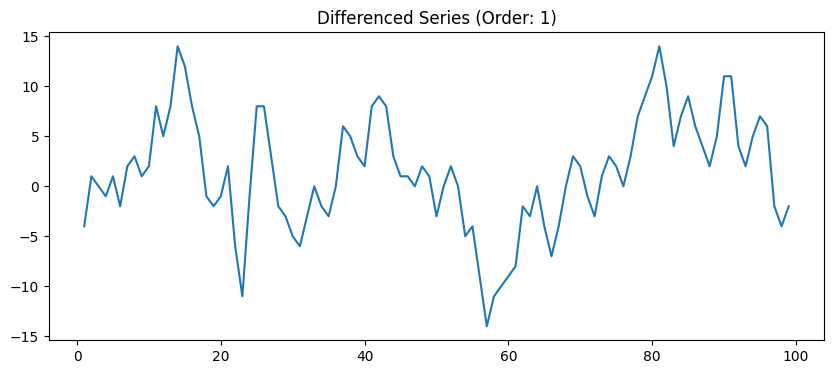

Order of Differencing: 1
ADF Statistic: -2.722238490442951
p-value: 0.07026846015272728
The series is not stationary after 1 order differencing.


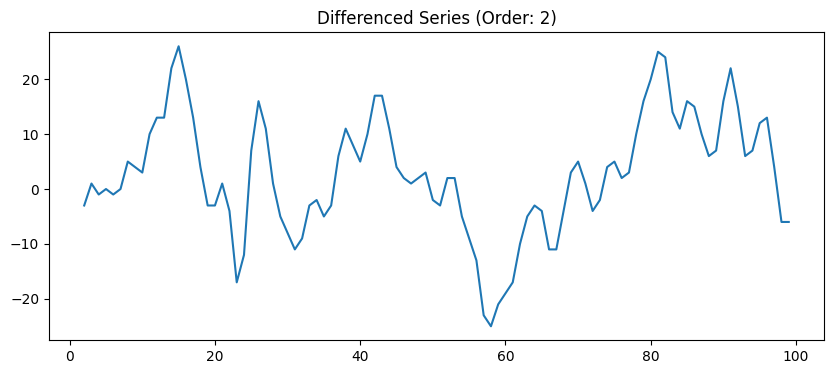

Order of Differencing: 2
ADF Statistic: -2.312105248657685
p-value: 0.16809350608005447
The series is not stationary after 2 order differencing.


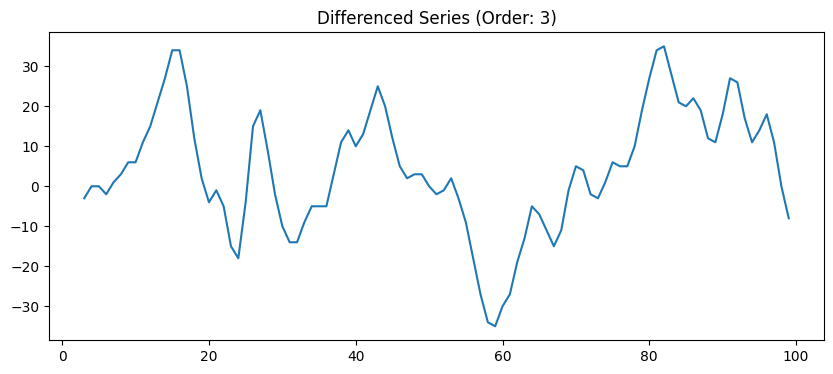

Order of Differencing: 3
ADF Statistic: -2.7627845483370894
p-value: 0.0637895057388239
The series is not stationary after 3 order differencing.


In [5]:
import matplotlib.pyplot as plt

def apply_and_check_differencing(series, max_diff_order=3):
    """
    Apply differencing up to a specified order and check stationarity after each step.
    """
    for i in range(1, max_diff_order + 1):
        # Apply differencing
        diff_series = series.diff(periods=i).dropna()

        # Perform the Augmented Dickey-Fuller test
        result = adfuller(diff_series)
        adf_statistic, p_value = result[0], result[1]

        # Plot the differenced series
        plt.figure(figsize=(10, 4))
        plt.plot(diff_series)
        plt.title(f'Differenced Series (Order: {i})')
        plt.show()

        # Print the results
        print(f'Order of Differencing: {i}')
        print(f'ADF Statistic: {adf_statistic}')
        print(f'p-value: {p_value}')

        # Check for stationarity
        if p_value <= 0.05:
            print(f"The series is stationary after {i} order differencing.")
            break
        else:
            print(f"The series is not stationary after {i} order differencing.")

# Apply differencing and check for stationarity
apply_and_check_differencing(df['value'])

We have a close call here between one and two diff orders. Differentiating time series too much may also reduce the performance of your ARIMA models. Let's have a closer look:

👉 Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(💡Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

<Figure size 1200x400 with 0 Axes>

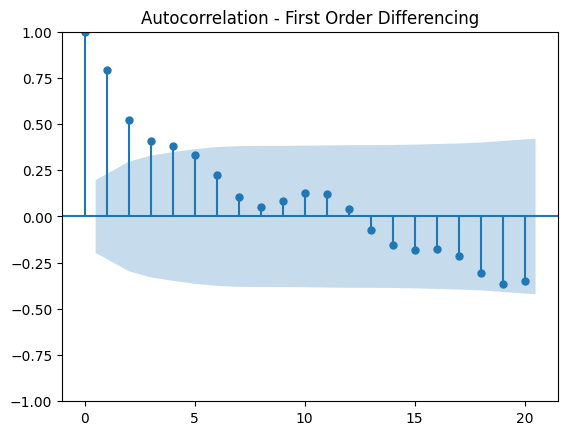

<Figure size 1200x400 with 0 Axes>

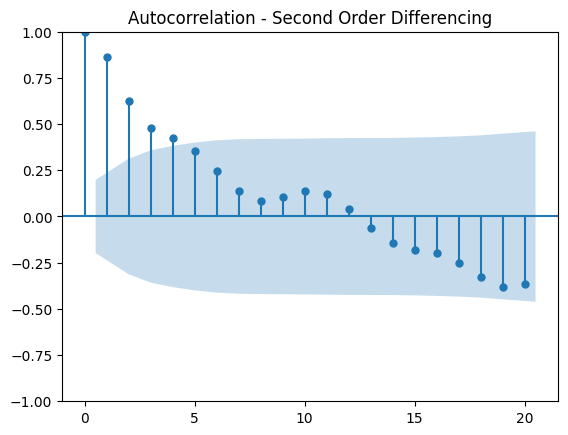

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

# Differencing the series
first_order_diff = df['value'].diff(periods=1).dropna()
second_order_diff = df['value'].diff(periods=2).dropna()

# Plotting Autocorrelation for first order differencing
plt.figure(figsize=(12, 4))
plot_acf(first_order_diff)
plt.title('Autocorrelation - First Order Differencing')
plt.show()

# Plotting Autocorrelation for second order differencing
plt.figure(figsize=(12, 4))
plot_acf(second_order_diff)
plt.title('Autocorrelation - Second Order Differencing')
plt.show()

In our "second order diff" autocorrelation plot, the lag coefficient n°1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n°0 which is always equal to 1)

👉 Let's (tentatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

In [7]:
y_diff = y.diff().dropna()

We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary ("I" refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

👉 determine `q`

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

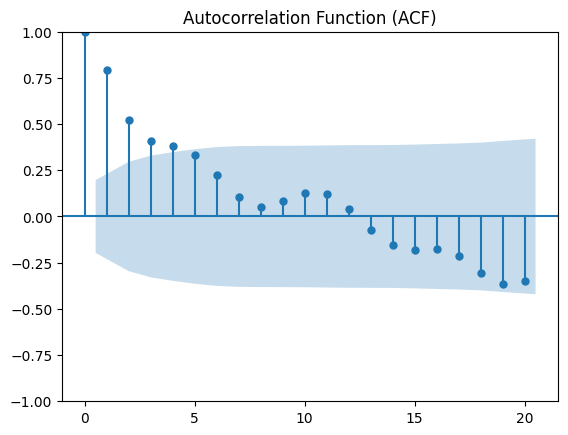

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf


plot_acf(y_diff, lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()

The maximum value we should consider for fitting our model seems to be q = 4. However, if we were to use Auto-ARIMA (more on this later) we would find that using q=2 yields ideal results so to begin with, let's try setting q=2. 

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

👉 Determine `p`

/Users/francoisgirard/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


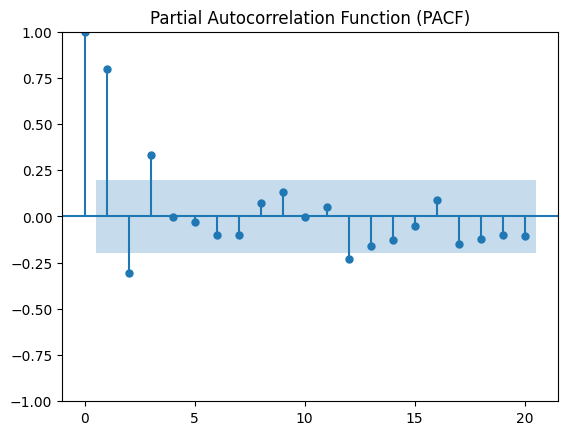

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf

# Assuming 'y_diff' is your differenced time series
# Replace 'y_diff' with the appropriate variable name if different
# For example, if you used first-order differencing, you might have a variable like 'first_order_diff'

plot_pacf(y_diff, lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

We could choose `p = 3` as the first 3 lag terms seem above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d`, and `q` for the ARIMA, 

👉 build the `arima_model` from `statsmodels`.
- fit the model
- print the model (`.summary`)

In [10]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['value'], order=(1, 1, 2))  # ARIMA(p,d,q)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Wed, 22 Nov 2023   AIC                            516.253
Time:                        13:36:41   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.6

☝️ If your p-values are too high, try to remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate the overall performance of your fit by minimizing the [`AIC - Akaike Information Criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remain low) and maintain a quasi-similar AIC score than other models

## 3. Evaluate model performance

👉 Visualize your model predictions with the `plot_predict()` method

- Look closely at the method default params, especially `dynamic` ones. 
- Do you think your model would have such a good performance in reality?

In [13]:
from statsmodels.graphics.tsaplots import plot_predict

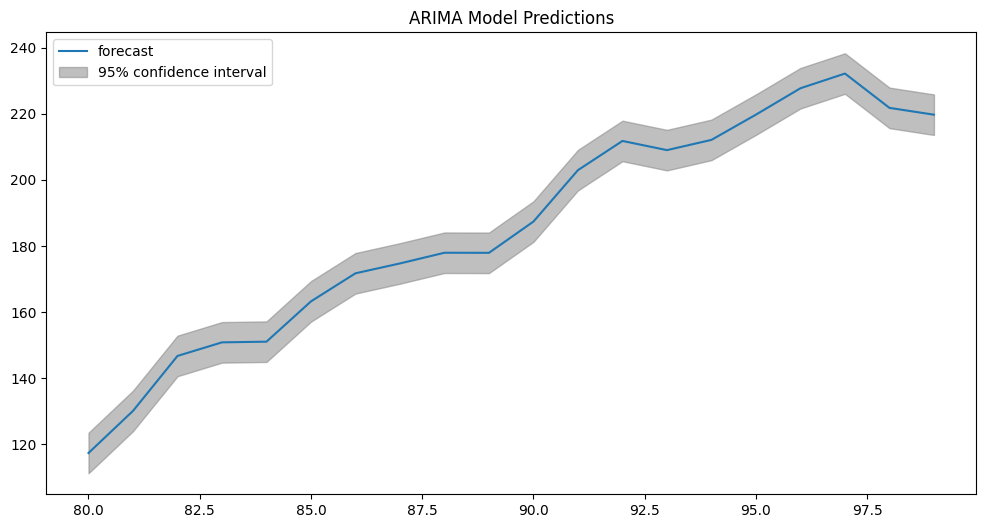

In [12]:
from statsmodels.graphics.tsaplots import plot_predict

# Define start and end indices for prediction
start_index = len(df) - 20
end_index = len(df) - 1

# Plot predictions
fig, ax = plt.subplots(figsize=(12, 6))
plot_predict(model_fit, start=start_index, end=end_index, dynamic=False, ax=ax)
plt.title('ARIMA Model Predictions')
plt.show()

☝️ `dynamic=False` makes use of all available values `y` to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

👉 Try to use `dynamic=True` to plot a prediction of the _last 15 values_ in a situation where the model only has _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ its previously predicted value for 86
- etc...iteratively until 100

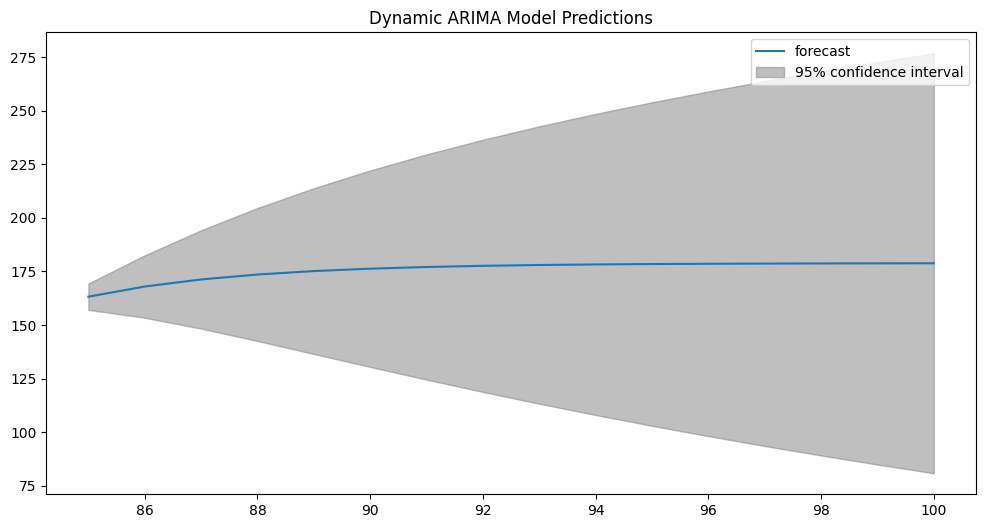

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

# Assuming model_fit is your fitted ARIMA model

# Define the start and end indices for dynamic prediction
start_index = 85
end_index = 100

# Plot dynamic predictions
fig, ax = plt.subplots(figsize=(12, 6))
plot_predict(model_fit, start=start_index, end=end_index, dynamic=True, ax=ax)
plt.title('Dynamic ARIMA Model Predictions')
plt.show()

☝️ That's still not a _true_ forecast! Why?

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` series during the fitting phase!
</details>

### 3.1 Out-of-Sample Forecasts (real "future")

👉 Create a train-test-split keep the last 15 data points only for the test set, and train your ARIMA on the train set only.

In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Splitting the dataset into train and test sets
train_size = len(df) - 15
train, test = df.iloc[:train_size], df.iloc[train_size:]

model = ARIMA(train['value'], order=(1, 1, 2))  # Example order, adjust as needed
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   85
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -216.970
Date:                Wed, 22 Nov 2023   AIC                            441.939
Time:                        13:43:03   BIC                            451.662
Sample:                             0   HQIC                           445.848
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7242      0.137      5.304      0.000       0.457       0.992
ma.L1          0.3901      0.175      2.233      0.026       0.048       0.732
ma.L2         -0.0907      0.161     -0.564      0.5

👉 We are "now" in step 85 and have never seen the future:
- Use the `get_forecast()` method on your fitted `arima` model to "forecast" the 15 next data points (i.e beyond the end of your train dataset) 

The method returns a `PredictionResultsWrapper` object from `statsmodels`.

**💻 Store this result in a variable named `forecast_results`.**  

It is hard to navigate at first, but here are some tips:
- You can find your forecasts in `forecast_results.predicted_mean`
- Your confidence intervals are given by `forecast_results.conf_int()`

In [15]:
forecast_results = model_fit.get_forecast(steps=15)
predicted_mean = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

print("Predicted values:")
print(predicted_mean)
print("\nConfidence intervals:")
print(conf_int)

Predicted values:
85    163.126755
86    167.854337
87    171.278009
88    173.757400
89    175.552953
90    176.853276
91    177.794958
92    178.476915
93    178.970782
94    179.328436
95    179.587446
96    179.775019
97    179.910857
98    180.009230
99    180.080471
Name: predicted_mean, dtype: float64

Confidence intervals:
    lower value  upper value
85   156.900943   169.352568
86   153.293168   182.415506
87   148.418247   194.137770
88   142.816332   204.698469
89   136.886107   214.219799
90   130.871579   222.834973
91   124.917267   230.672648
92   119.105586   237.848244
93   113.480287   244.461277
94   108.061165   250.595707
95   102.853358   256.321534
96    97.853261   261.696776
97    93.052289   266.769425
98    88.439253   271.579207
99    84.001859   276.159082


👉 Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

👉 Try to also plot your previous 85 `y` real data points to better grasp model performance relative to the past

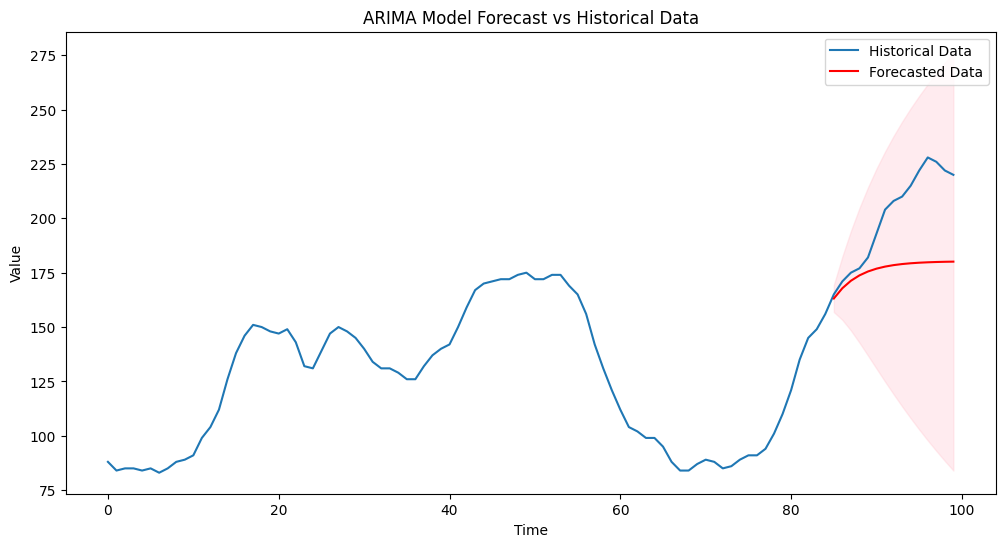

In [16]:
import matplotlib.pyplot as plt

# Plot the historical data
plt.figure(figsize=(12, 6))
plt.plot(df['value'], label='Historical Data')

# Plot the forecasted values
plt.plot(predicted_mean.index, predicted_mean, color='red', label='Forecasted Data')

# Plot the confidence intervals
plt.fill_between(conf_int.index,
                 conf_int['lower value'],
                 conf_int['upper value'], color='pink', alpha=0.3)

plt.title('ARIMA Model Forecast vs Historical Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.show()

### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

👉 Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals anyway if you want)

Note: residuals are constructed by 'seeing' all data as in `plot_predict(dynamic=False)`

Also, try to plot a histogram or KDE fit of the residuals to see if they are approximately normally distributed.

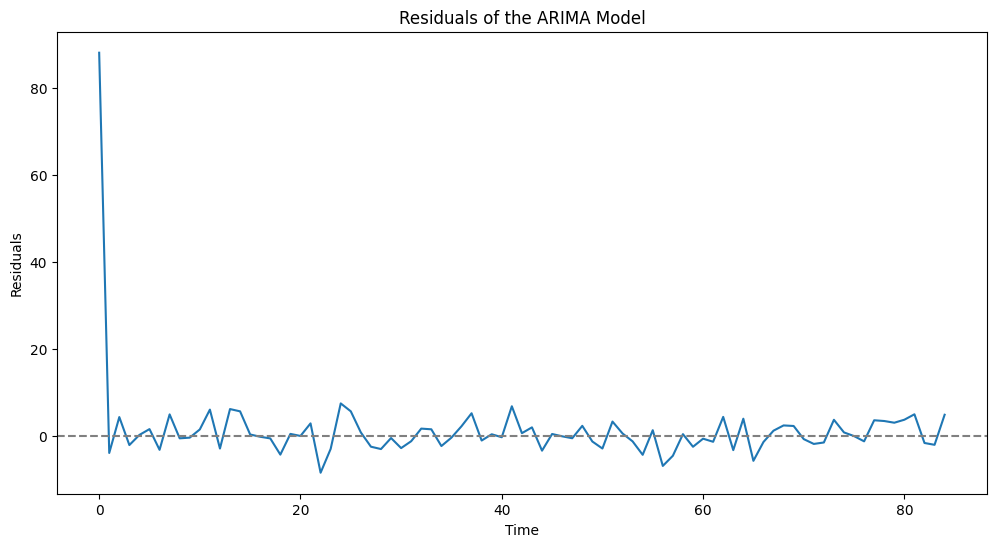

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(model_fit.resid)
plt.title('Residuals of the ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(y=0, linestyle='--', color='gray')
plt.show()

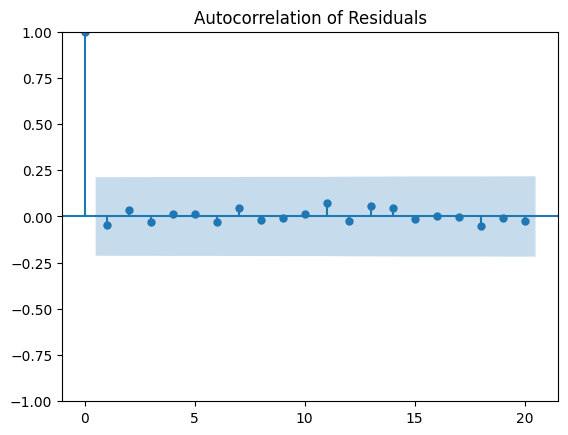

In [18]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(model_fit.resid, lags=20)
plt.title('Autocorrelation of Residuals')
plt.show()

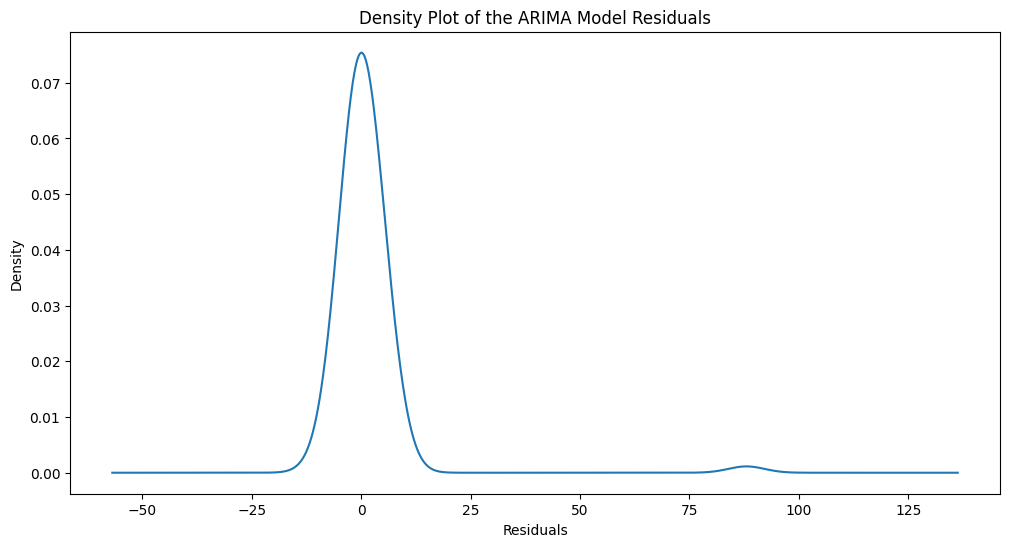

In [19]:
plt.figure(figsize=(12, 6))
model_fit.resid.plot(kind='kde')
plt.title('Density Plot of the ARIMA Model Residuals')
plt.xlabel('Residuals')
plt.show()

## 3.3 Cross-validated performance metrics

👉 Below are the given the most common performance metrics for time series

In [20]:
import numpy as np
from statsmodels.tsa.stattools import acf

def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'acf1':acf1,
        'corr':corr,
        'minmax':minmax
    })

    return forecast

👉 Play with your ARIMA hyper-parameters and see the impact on your forecast performance

In [22]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Set up your ranges
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]

# Store results
results = []

# Loop through combinations
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train['value'], order=(p, d, q))
                model_fit = model.fit()
                predictions = model_fit.forecast(steps=len(test))
                rmse = np.sqrt(mean_squared_error(test['value'], predictions))
                results.append((p, d, q, model_fit.aic, model_fit.bic, rmse))
            except:
                continue


/Users/francoisgirard/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/francoisgirard/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/francoisgirard/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/francoisgirard/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting

In [23]:
# Convert to DataFrame for easier viewing
results_df = pd.DataFrame(results, columns=['p', 'd', 'q', 'AIC', 'BIC', 'RMSE'])

# Sort by your chosen metric
sorted_results = results_df.sort_values(by='RMSE')
print(sorted_results.head())


    p  d  q         AIC         BIC       RMSE
17  2  1  2  443.516369  455.670453  26.042333
9   1  1  0  449.461880  454.323514  28.365648
11  1  1  2  441.939017  451.662284  30.264522
16  2  1  1  442.051527  451.774794  31.798526
10  1  1  1  440.109413  447.401863  32.382382


In [25]:
# Assuming best_model is the fitted ARIMA model with best hyperparameters
best_p, best_d, best_q = sorted_results.iloc[0][['p', 'd', 'q']]
best_model = ARIMA(train['value'], order=(best_p, best_d, best_q))
best_model_fit = best_model.fit()
forecast = best_model_fit.get_forecast(steps=15)

## 4 Grid Search

Try to run a Grid Search for (p,d,q) using `pmdarima`. Use at least
- `test='adf'`
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [ ]:
import pmdarima as pm

model = pm.auto_arima(
    y_train, 
    start_p=0, max_p=3,
    start_q=0, max_q=3, 
    d=None,           # let model determine 'd'
    test='adf',       # using adf test to find optimal 'd'
    trace=True, error_action='ignore',  suppress_warnings=True
)

print(model.summary())

## (Optional) Cross-validate the Performance of your Model

In practice, results and Grid Search should always be cross-validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create contiguous K-folds to truly evaluate the performance of your model and find the best hyperparams after cross-validation.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png'>

**ARIMA - Cross-Validation using TimeSeriesSplit + Grid Search**

In [29]:
# YOUR CODE HERE

In [28]:
df.sort_values('AIC').groupby('(p, d, q)').mean()['AIC'].sort_values()

☝️ Our initial choice of model (1, 1, 2) is not so bad!
Notice that the dataset (100 data points) is in reality way too small to cross-validate anything!